# Tarea 2 - Regresion Polinomial & Feature engineering

## Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 30 de mayo. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm

### Pre-procesamiento de CSV

In [2]:
# Se cargan los datos del CSV
df = pd.read_csv("covid19-data.csv")

# Se extrae la fila correspondiente a guatemala
df = df[ df['Country/Region']=="Guatemala" ]

# Se extraen las fechas de los headers (lista)
fechas = list(df.columns.values)[4:]

# Se extrae el número de casos confirmados (lista)
casos = df.loc[:, "1/22/20":].values.tolist()

# Los casos vienen una lista bidimensional a pesar de que solo la primera "fila" 
# del array tiene datos. Extraemos esta primera fila
casos = casos[0]

# Se crea un nuevo data frame con las dos listas extraídas
df = pd.DataFrame(list(zip(fechas, casos)), columns =['Date', 'Confirmed_Cases'])

# Se convierten las fechas a "datetime"
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format = True)

# Se extraen las filas donde el número de casos confirmados es mayor a 0
df = df[df["Confirmed_Cases"] > 1]

### Gráfica de Datos

Como se puede observar, los datos no cuentan con una tendencia lineal, por lo que ajustar un modelo de este tipo resultaría en una predicción poco satisfactoria.

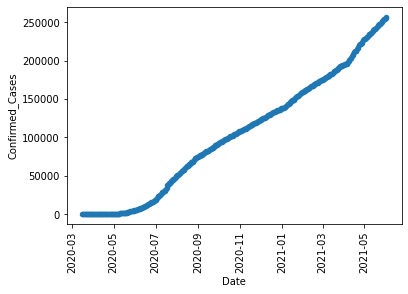

In [3]:
df.plot.scatter(x="Date", y="Confirmed_Cases")
plt.xticks(rotation=90)
plt.show()

### Transformación de Variables

Para poder generar un mejor modelo lineal con los datos se decidió transformar la variable independiente con el objetivo de linealizarla. Para esto se hizo una transformación inicial T1, la cual consistía en obtener el logaritmo de los datos y luego obtener su raíz cuadrada

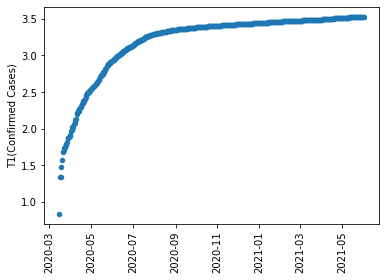

In [4]:
# Transformación inicial
T1 = np.log(df["Confirmed_Cases"]) ** (1/2)

# Se almacenan los datos transformados en una nueva columna
df["T1(Confirmed_Cases)"] = T1

# Se grafican los resultados
df.plot.scatter(x = "Date", y = "T1(Confirmed_Cases)")
plt.xlabel("")
plt.ylabel("T1(Confirmed Cases)")
plt.xticks(rotation=90)
plt.show()

Al observar estos resultados, se pudo denotar que los puntos seguían una tendencia similar a la de una ecuación exponencial de la siguiente forma: $$-Ae^{-Bx} + C$$ 

Se experimentó con las constantes de la ecuación (A, B y C) hasta obtener un modelo que se acercara lo más posible a la tendencia mostrada por los datos reales. 

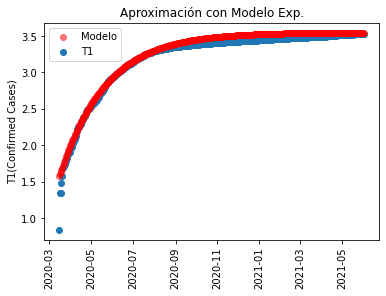

In [5]:
x_data = np.arange(1, len(df["Confirmed_Cases"]) + 1, 1)
y_data = -np.exp(-x_data * 0.015) * 2 + 3.55
df["Modelo"] = y_data

plot_T1 = plt.scatter(x = df["Date"], y = df["T1(Confirmed_Cases)"], label="T1")
plot_modelo = plt.scatter(x = df["Date"], y = df["Modelo"], c = "r", alpha = 0.5, label="Modelo")
plt.legend(handles=[plot_modelo, plot_T1])
plt.title("Aproximación con Modelo Exp.")
plt.xlabel("")
plt.ylabel("T1(Confirmed Cases)")
plt.xticks(rotation=90)
plt.show()

Luego, para poder "despejar a la X" (linealizar el modelo) simplemente se aplicó la operación inversa a la que se utilizó para obtener "y_data" como una segunda transformación T2. A pesar de todo este trabajo, los resultados no fueron los esperados. La gráfica presenta una ligera "pancita" que se aleja de la tendencia lineal esperada.

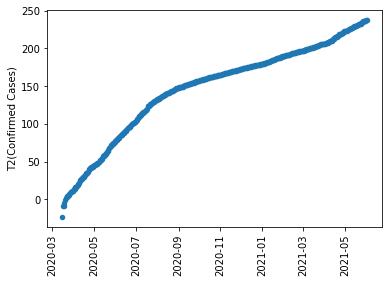

In [6]:
T2 = np.log((T1 - 3.6) / -1.98) / -0.014
df["T2(Confirmed_Cases)"] = T2

ax = df.plot.scatter(x = "Date", y = "T2(Confirmed_Cases)")
plt.xlabel("")
plt.ylabel("T2(Confirmed Cases)")
plt.xticks(rotation=90)
plt.show()

### Definición de Grafo

Se define el grafo de tensorflow encargado de hacer la regresión lineal de los datos dados.

In [7]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [8]:
# Definición de función encargada de crear un grafo para hacer una regresión lineal
def Create_LinRegGraph(NumFilas, NumParams):

    # Se reinicia la creación del grafo creado
    tf.reset_default_graph()

    # Se crea un objeto de tipo grafo
    grafo = tf.Graph()

    # Se incluyen nodos dentro del grafo
    with grafo.as_default():

        # Input: Se definen los datos de entrenamiento
        # X: Tantas filas como datos (None para un tamaño variable). Tantas columnas como features
        # Y: Tantas filas como datos (None para un tamaño variable). 1 Columna
        X = tf.placeholder(tf.float32, [None, NumParams], "X")
        Y = tf.placeholder(tf.float32, [None, 1], "Y")

        # Input: Learning rate 
        learning_rate = tf.placeholder(dtype="float", name="lr")

        # Se inicializan los parámetros correspondientes a las pendientes (m's) y el bias
        params = tf.Variable(tf.zeros((NumParams, 1)), name="Theta", dtype=tf.float32)

        # Predicción de la salida dados los parámetros M y B
        with tf.name_scope("Predict"):
            Y_hat = tf.matmul(X, params)

        # Cálculo del error 
        with tf.name_scope("Error"):
            error = tf.reduce_sum(tf.pow(Y_hat - Y, 2)) / (2 * NumFilas)

            # Incluir el error en la parte de "Scalars" de tensorboard
            error_summary = tf.summary.scalar("Error", error)

        # Obtener el valor de los gradientes para M y B
        grads_params = tf.gradients(error, params)

        # La operación de gradiente es acoplada a un print para facilitar el debugging
        # grads_print = tf.tuple(grads_params, control_inputs=[tf.print(grads_params)])
        grads_print = tf.tuple(grads_params, control_inputs=[])

        # El gradiente retorna un tensor de más dimensiones de las que regresó. 
        # Ejemplo: Para un tensor de "params" 2D, tf.gradients retorna un tensor 3D con 2 elementos.
        # Se "aplanan" los datos para regresar a la forma original de params
        grads = tf.reshape(grads_print[0], tf.shape(params))

        # Actualizar los parámetros del algoritmo
        with tf.name_scope("Update"):
            delta_params = tf.assign(params, params - learning_rate * grads)

        # Inicializar variables globales
        init = tf.global_variables_initializer()

    return grafo, init, [X, Y], [learning_rate, delta_params, error_summary, params]

![grafo](grafo.png)

### Función de Entrenamiento

Se define una función de entrenamiento que hace uso del grafo definido previamente para poder generar un proceso de entrenamiento para un modelo de regresión lineal.

In [9]:
# Función de entrenamiento
def Train(x, y, lr, epochs, metadata):

    # Se extraen las dimensiones de los datos de entrada
    num_fil = x.shape[0]
    num_col = x.shape[1]

    # Se crea un grafo nuevo con el número de columnas de X
    grafo, init, linRegIO, Nodes = Create_LinRegGraph(num_fil, num_col)

    # Datos de entrenamiento (X) y labels (Y)
    X, Y = linRegIO

    # Se extrae la definición de los diferentes nodos utilizados luegos por TF
    learning_rate = Nodes[0]
    delta_params = Nodes[1]
    error_summary = Nodes[2]
    params = Nodes[3]

    with tf.Session(graph = grafo) as sess:
        
        # Inicializa todas las variables de ser necesario
        tf.initialize_all_variables().run()

        # Crea un directorio para tensorboard
        # Generalmente el directorio "padre" de tensorboard es "graphs" pero puede cambiarse
        writer = tf.summary.FileWriter((f'./graphs/{metadata}  model_lr={str(lr)}, epochs={str(epochs)}, no_feat={str(num_col)}'), sess.graph)

        # Inicializar el grafo
        sess.run(init)

        # Iterar para cada Epoch
        for epoch in range(epochs):
            
            # Se definen los inputs del grafo
            inputs_grafo = {
                X: x,
                Y: y,
                learning_rate: lr
            }

            # Se corre el grafo con los datos elegidos
            sess.run(delta_params, feed_dict=inputs_grafo)

            # Se agregan todos los escalares al tensorboard
            e = sess.run(error_summary, feed_dict=inputs_grafo)
            writer.add_summary(e, epoch)
        
        # Se extraen los parámetros resultantes de la regresión
        theta = params.eval()
            
        # Finalizar el "writer" hacia tensor board
        writer.close()

    return theta

### Proceso de Entrenamiento

Para iniciar tensorboard, navegar a la carpeta que contiene la carpeta de "graphs" y luego utilizar el comando: 

tensorboard --logdir="./graphs" --port 6006

In [10]:
# Se convierten los arrays unidimensionales de numpy en arrays bidimensionales
x_train = np.reshape(x_data, (-1,1))
y_train = np.reshape(np.array(T2), (-1,1))

# Se agrega una columna de 1's a x_train
x_train = np.c_[x_train, np.ones(x_data.shape)]

# Se realiza el entrenamiento
params_linreg = Train(x=x_train, y=y_train, lr=0.0000001, epochs=500, metadata="T2_P1")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Evaluar Resultados

Se puede observar que los resultados obtenidos no son particularmente satisfactorios debido a que la transformación aplicada para "linealizar" los datos no fue tan exitosa como se creía inicialmente. 

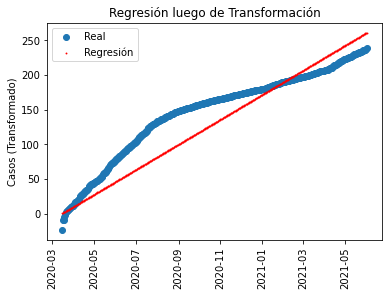

In [11]:
x_model = np.arange(1, len(df["Confirmed_Cases"]) + 1, 1)
y_model = params_linreg[0] * x_model + params_linreg[1]
y_real = df["T2(Confirmed_Cases)"]

real = plt.scatter(x=df["Date"], y=y_real, label="Real")
model = plt.scatter(x=df["Date"], y=y_model, c="r", s=0.8, label="Regresión")
plt.title("Regresión luego de Transformación")
plt.ylabel("Casos (Transformado)")
plt.legend(handles=[real, model])
plt.xticks(rotation=90)
plt.show()

## Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

### Carga de los Datos

In [14]:
dataset = pd.read_csv('winequality-red.csv')

### Entrenamiento de Modelos

In [20]:
# Se extraen las variables a combinar en un numpy array
wine_data = dataset[["volatile acidity", "citric acid", "quality"]].values

# Se "shufflelean" los datos
rng = np.random.default_rng()
rng.shuffle(wine_data, axis=0)

# Se extrae el número total de datos y de features
num_datos = wine_data.shape[0]
num_feat = wine_data.shape[1] - 1

# Límite superior para extraer los datos de entrenamiento (80%)
split_ind = int(num_datos*0.8)

# Extracción de datos de entrenamiento (80%) y de validación (20%)
train_data = wine_data[0:split_ind, :]
test_data = wine_data[split_ind:num_datos, :]

# Se dividen los datos en las "Xs" y "Y"
train_x = train_data[:, 0:num_feat]
train_y = train_data[:, num_feat]

# Se altera el vector de "y's" para 
train_y = np.reshape(train_y, (-1,1))

In [22]:
# Crea un objeto de features polinomiales de grado 2
poly = PolynomialFeatures(2)

# Genera las features polinomiales
features = poly.fit_transform(X_data)

# Número de features
NumFeat = feat.shape[1]

array([7., 7., 6., ..., 5., 6., 6.])

In [ ]:
params_linreg = Train(x=x_train, y=y_train, lr=0.0000001, epochs=500)

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
